# **Steering Angle prediction with CNN**

### **Importing Libraries**

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import matplotlib.image as mpimg
from imgaug import augmenters as iaa
import cv2
import random
from PIL import Image
import time

### **Loading data info**
The **data** dataframe contains image paths, and driving log including steering angel, throttle, brake and speed

In [107]:
def getName(filePath):
    a = filePath.split('\\')[-1]
    b = filePath.split('\\')[-2]
    c = filePath.split('\\')[-3]
    return c + '/' + b +'/' + a

In [108]:
def importDataInfo(path):
    columns = ['Center', 'Left', 'Right', 'Steering', 'Throttle', 'Brake', 'Speed']
    data = pd.read_csv(os.path.join(path, 'driving_log.csv'), names=columns)
    #### REMOVE FILE PATH AND GET ONLY FILE NAME
    data['Center'] = data['Center'].apply(getName)
    data['Left'] = data['Left'].apply(getName)
    data['Right'] = data['Right'].apply(getName)

    print('Total Images Imported', data.shape[0])
    return data

In [109]:
path = 'Dataset'
data = importDataInfo(path)
data

Total Images Imported 10491


,Center,Left,Right,Steering,Throttle,Brake,Speed
0,Dataset/IMG/center_2023_01_22_17_25_18_013.jpg,Dataset/IMG/left_2023_01_22_17_25_18_013.jpg,Dataset/IMG/right_2023_01_22_17_25_18_013.jpg,0.0,0.0,0.0,14.65444
1,Dataset/IMG/center_2023_01_22_17_25_18_091.jpg,Dataset/IMG/left_2023_01_22_17_25_18_091.jpg,Dataset/IMG/right_2023_01_22_17_25_18_091.jpg,0.0,0.0,0.0,14.53191
2,Dataset/IMG/center_2023_01_22_17_25_18_178.jpg,Dataset/IMG/left_2023_01_22_17_25_18_178.jpg,Dataset/IMG/right_2023_01_22_17_25_18_178.jpg,0.0,0.0,0.0,13.82092
3,Dataset/IMG/center_2023_01_22_17_25_18_259.jpg,Dataset/IMG/left_2023_01_22_17_25_18_259.jpg,Dataset/IMG/right_2023_01_22_17_25_18_259.jpg,0.0,0.0,0.0,13.80480
4,Dataset/IMG/center_2023_01_22_17_25_18_335.jpg,Dataset/IMG/left_2023_01_22_17_25_18_335.jpg,Dataset/IMG/right_2023_01_22_17_25_18_335.jpg,0.0,0.0,0.0,14.19830
...,...,...,...,...,...,...,...
10486,Dataset/IMG/center_2023_01_22_17_53_13_321.jpg,Dataset/IMG/left_2023_01_22_17_53_13_321.jpg,Dataset/IMG/right_2023_01_22_17_53_13_321.jpg,0.0,0.0,0.0,27.72017
10487,Dataset/IMG/center_2023_01_22_17_53_13_414.jpg,Dataset/IMG/left_2023_01_22_17_53_13_414.jpg,Dataset/IMG/right_2023_01_22_17_53_13_414.jpg,0.0,0.0,0.0,27.44341
10488,Dataset/IMG/center_2023_01_22_17_53_13_490.jpg,Dataset/IMG/left_2023_01_22_17_53_13_490.jpg,Dataset/IMG/right_2023_01_22_17_53_13_490.jpg,0.0,0.0,0.0,27.22400
10489,Dataset/IMG/center_2023_01_22_17_53_13_557.jpg,Dataset/IMG/left_2023_01_22_17_53_13_557.jpg,Dataset/IMG/right_2023_01_22_17_53_13_557.jpg,0.0,0.0,0.0,27.06060


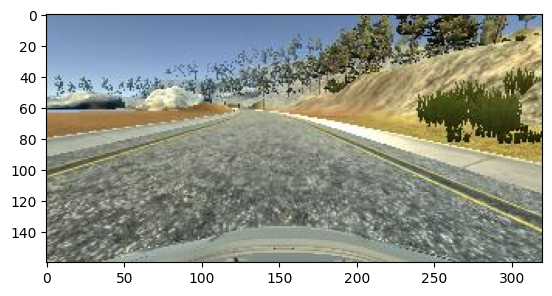

In [111]:
img = mpimg.imread(data['Center'][0])
imgplot = plt.imshow(img)
plt.show()

### **Balancing Data**

In [112]:

def balanceData(data,display=True):
    nBin = 31
    # samplesPerBin = 500
    samplesPerBin = 7000
    hist, bins = np.histogram(data['Steering'], nBin)
    if display:
        center = (bins[:-1] + bins[1:]) * 0.5
        plt.bar(center, hist, width=0.06)
        plt.plot((np.min(data['Steering']), np.max(data['Steering'])), (samplesPerBin, samplesPerBin))
        plt.show()
    removeindexList = []
    for j in range(nBin):
        binDataList = []
        for i in range(len(data['Steering'])):
            if data['Steering'][i] >= bins[j] and data['Steering'][i] <= bins[j + 1]:
                binDataList.append(i)
        binDataList = shuffle(binDataList)
        binDataList = binDataList[samplesPerBin:]
        removeindexList.extend(binDataList)

    print('Removed Images:', len(removeindexList))
    # print(type(removeindexList))
    # print(removeindexList)
    data.drop(data.index[removeindexList], inplace=True)
    print('Remaining Images:', len(data))
    # print(type(data))

    if display:
        hist, _ = np.histogram(data['Steering'], (nBin))
        plt.bar(center, hist, width=0.06)
        plt.plot((np.min(data['Steering']), np.max(data['Steering'])), (samplesPerBin, samplesPerBin))
        plt.show()
    return data


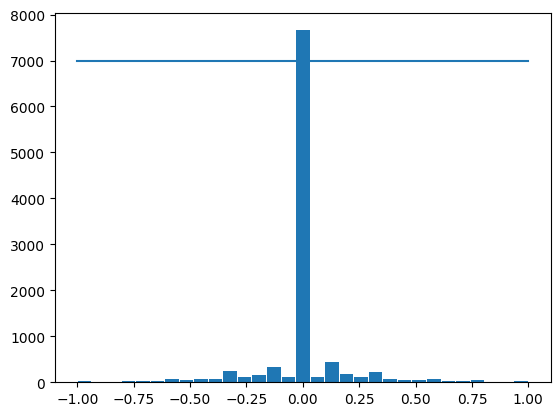

Removed Images: 658
Remaining Images: 9833


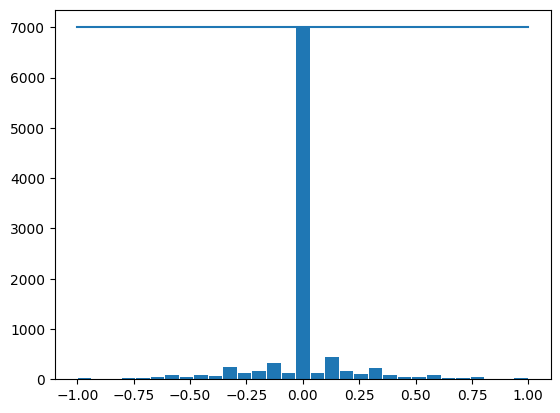

9833


In [113]:
data = balanceData(data, display=True)
# data = pd.DataFrame(data)
print(len(data))
# print(data)

### **Spliting training validating data**

In [114]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [116]:
numpydata = data.values
print(numpydata[:,:])

[['Dataset/IMG/center_2023_01_22_17_25_18_013.jpg'
  'Dataset/IMG/left_2023_01_22_17_25_18_013.jpg'
  'Dataset/IMG/right_2023_01_22_17_25_18_013.jpg' ... 0.0 0.0 14.65444]
 ['Dataset/IMG/center_2023_01_22_17_25_18_091.jpg'
  'Dataset/IMG/left_2023_01_22_17_25_18_091.jpg'
  'Dataset/IMG/right_2023_01_22_17_25_18_091.jpg' ... 0.0 0.0 14.53191]
 ['Dataset/IMG/center_2023_01_22_17_25_18_178.jpg'
  'Dataset/IMG/left_2023_01_22_17_25_18_178.jpg'
  'Dataset/IMG/right_2023_01_22_17_25_18_178.jpg' ... 0.0 0.0 13.82092]
 ...
 ['Dataset/IMG/center_2023_01_22_17_53_13_490.jpg'
  'Dataset/IMG/left_2023_01_22_17_53_13_490.jpg'
  'Dataset/IMG/right_2023_01_22_17_53_13_490.jpg' ... 0.0 0.0 27.224]
 ['Dataset/IMG/center_2023_01_22_17_53_13_557.jpg'
  'Dataset/IMG/left_2023_01_22_17_53_13_557.jpg'
  'Dataset/IMG/right_2023_01_22_17_53_13_557.jpg' ... 0.0 0.0 27.0606]
 ['Dataset/IMG/center_2023_01_22_17_53_13_631.jpg'
  'Dataset/IMG/left_2023_01_22_17_53_13_631.jpg'
  'Dataset/IMG/right_2023_01_22_17_53_

In [118]:
xTrain, xVal, yTrain, yVal = train_test_split(numpydata[:,:1], numpydata[:,3:], test_size=0.2,random_state=10)
print('Total Training Images: ',len(xTrain))
print('Total Validation Images: ',len(xVal))

Total Training Images:  7866
Total Validation Images:  1967


### **Bulding CNN Model**

In [119]:
import tensorflow as tf

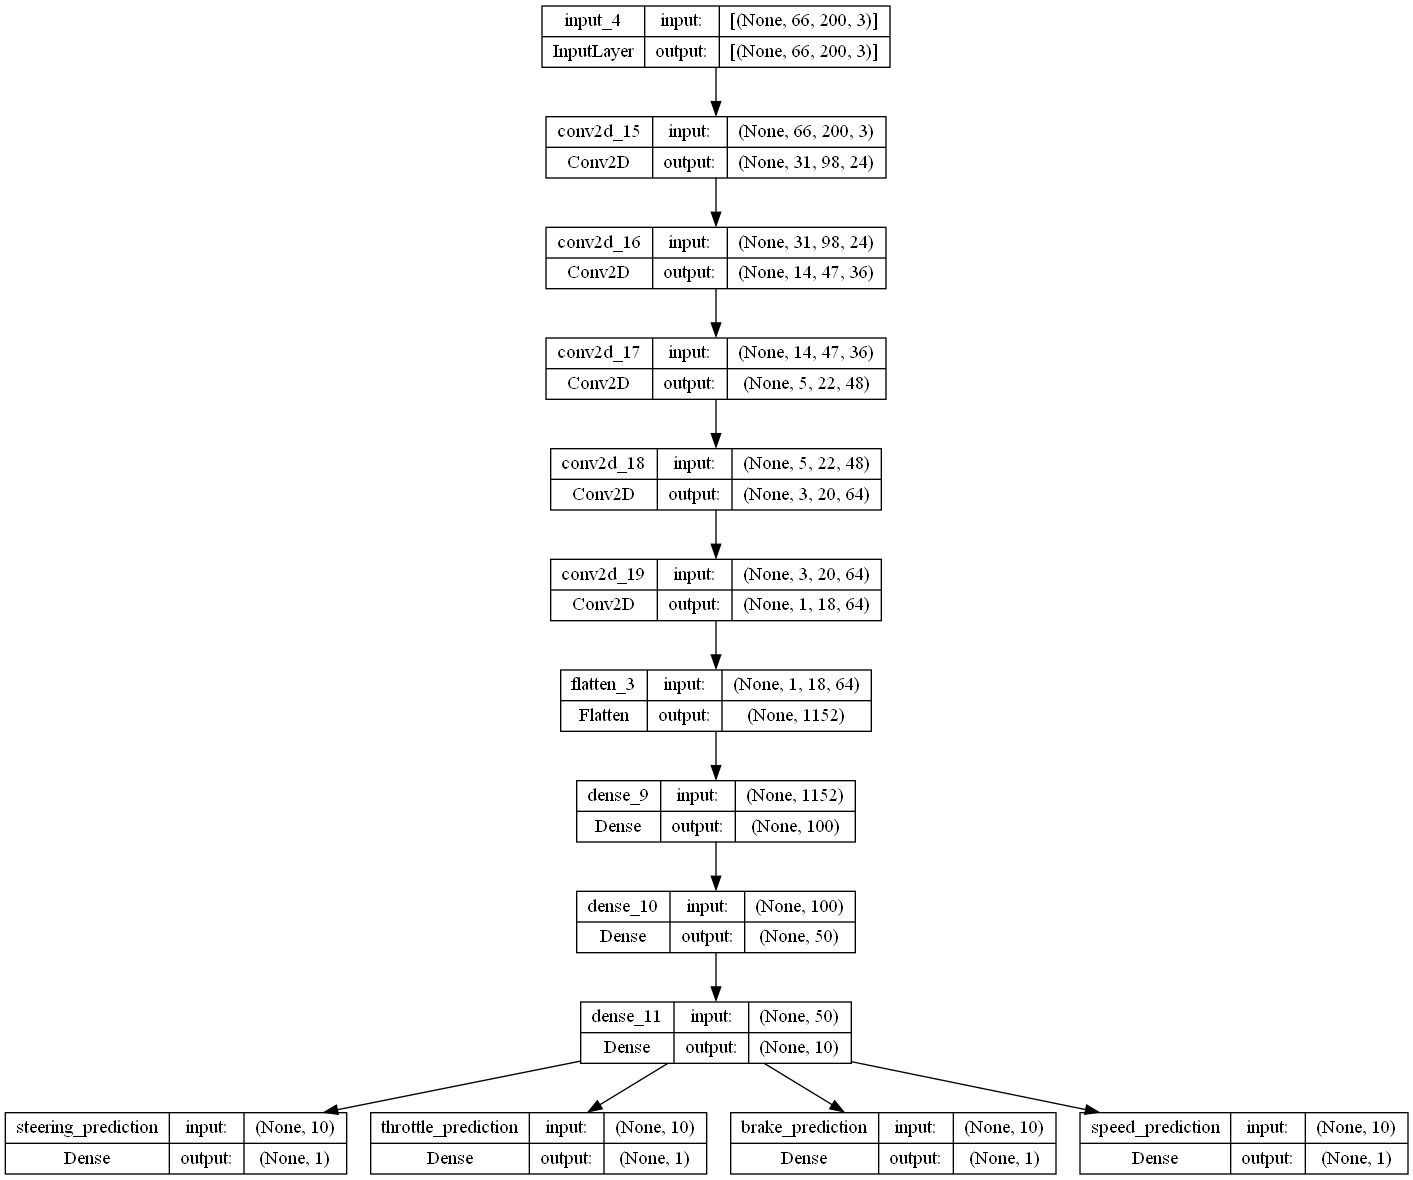

In [124]:
input_layer = tf.keras.layers.Input(shape=(66, 200, 3))
# input_layer = tf.keras.models.Sequential()
conv = (tf.keras.layers.Conv2D(24, (5, 5), (2, 2), input_shape=(66, 200, 3), activation='elu'))(input_layer)
conv = (tf.keras.layers.Conv2D(36, (5, 5), (2, 2), activation='elu'))(conv)
conv = (tf.keras.layers.Conv2D(48, (5, 5), (2, 2), activation='elu'))(conv)
conv = (tf.keras.layers.Conv2D(64, (3, 3), activation='elu'))(conv)
conv = (tf.keras.layers.Conv2D(64, (3, 3), activation='elu'))(conv)

flatten = (tf.keras.layers.Flatten())(conv)

dense = (tf.keras.layers.Dense(100, activation='elu'))(flatten)
dense = (tf.keras.layers.Dense(50, activation='elu'))(dense)
dense = (tf.keras.layers.Dense(10, activation='elu'))(dense)

steering_output = tf.keras.layers.Dense(1, activation='elu', name = "steering_prediction")(dense)
throttle_output = tf.keras.layers.Dense(1, activation='elu', name = "throttle_prediction")(dense)
brake_output = tf.keras.layers.Dense(1, activation='elu', name = "brake_prediction")(dense)
speed_output = tf.keras.layers.Dense(1, activation='elu', name = "speed_prediction")(dense)

output_list = [steering_output, throttle_output, brake_output, speed_output]

Model = tf.keras.Model(inputs = input_layer, outputs = output_list)
# model_1.add(output_list)

Model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss=['mse','mse','mse','mse'], metrics='acc')
tf.keras.utils.plot_model(model_1, show_shapes=True)


In [125]:
Model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 66, 200, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 31, 98, 24)   1824        ['input_5[0][0]']                
                                                                                                  
 conv2d_21 (Conv2D)             (None, 14, 47, 36)   21636       ['conv2d_20[0][0]']              
                                                                                                  
 conv2d_22 (Conv2D)             (None, 5, 22, 48)    43248       ['conv2d_21[0][0]']        

### **Image Preprocessing**

In [126]:
def preProcess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255

    # im = Image.fromarray(img,'RGB')
    # im.show()
    # time.sleep(1)
    return img

### **Image Augmentation**

In [127]:
def augmentImage(imgPath,val):
    img =  mpimg.imread(imgPath)
    if np.random.rand() < 0.5:
        pan = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
        img = pan.augment_image(img)
    if np.random.rand() < 0.5:
        zoom = iaa.Affine(scale=(1, 1.2))
        img = zoom.augment_image(img)
    if np.random.rand() < 0.5:
        brightness = iaa.Multiply((0.2, 1.2))
        img = brightness.augment_image(img)
    if np.random.rand() < 0.5:
        img = cv2.flip(img, 1)
        val[0] = -val[0]
    return img, val


### **Batch generation**

In [129]:
xTrain[0][0]

'Dataset/IMG/center_2023_01_22_17_25_44_186.jpg'

In [130]:
def batchGen(imagesPath, val, batchSize, trainFlag):
    while True:
        imgBatch = []
        driving_log = []

        for i in range(batchSize):
            index = random.randint(0, len(imagesPath) - 1)
            if trainFlag:
                img, output = augmentImage(imagesPath[index][0], val[:][index])
            else:
                img = mpimg.imread(imagesPath[index])
                output = val[:][index]
            img = preProcess(img)
            imgBatch.append(img)
            driving_log.append(output)
        yield (np.asarray(imgBatch), np.asarray(driving_log))

## **Fit model**

In [131]:
yTrain = np.asarray(yTrain).astype(np.float32)
yVal = np.asarray(yVal).astype(np.float32)

In [132]:
history = model_1.fit(batchGen(xTrain, yTrain, 100, 1),
                                  steps_per_epoch=300,
                                  epochs=10,
                                  validation_data=batchGen(xVal, yVal, 100, 0),
                                  validation_steps=200)

Epoch 1/10
 54/300 [====>.........................] - ETA: 3:30 - loss: 483.4838 - steering_prediction_loss: 115.9514 - throttle_prediction_loss: 114.1317 - brake_prediction_loss: 116.7652 - speed_prediction_loss: 136.6355 - steering_prediction_acc: 0.0725 - throttle_prediction_acc: 0.0707 - brake_prediction_acc: 0.1106 - speed_prediction_acc: 0.3201

KeyboardInterrupt: 

### **Saving Model**

In [ ]:
Model.save('Behavior.h5')
print('Model Saved')

### **Training History**

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()